In [2]:
# Plan of Action
# plot all tackle distance data to determine methodology for picking playmaking threshold
    # Find distance between tackler and ball when ball carrier gets ball
# come up with cone of influence equation 
# distance delta pipeline


 #cone is where the defender could make the tackle

# ONLY LOOK AT RUN PLAYS FOR NOW
# Chase down efficiency
    # How well does each defender's cone move towards the ball carrier
        # Have a minimum distance to be able to be considered for the play
            # distribution of tackler's distance moved from play, get the upper quartile as the min distance
        # How do we judge how effectively they move there?
            # is it just distance delta?
                # consider derivative of distance over time as metric in concern
            # is it moving to final tackle location
            # is it cone overlap delta?

# Once cone overlap reaches threshold, chaser converts to prospective tackler
    # Use this to consider conversion rates for chasers

# Tackle probability - for all prospective tacklers
    # after ball carrier is in cone, how well does tackler make tackle
        # cone overlap integral
        # how fast does cone overlap area increase
        # 
##

#bivariate distribution - x is normally distributed, y is skewed distributed
# these distributions are centered on the player's location and have stdev of some formula of velocity and weight
#the combined distribution comes from multipying the x and y distribution because we're assuming independence


In [3]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
import math
import matplotlib.pyplot as plt

In [4]:
# Game info - id, week, date, time, teams, scores
games = pd.read_csv("games.csv")


In [5]:
plays = pd.read_csv("plays.csv")
plays['gameClockSeconds'] = pd.to_datetime(plays['gameClock'], format='%M:%S').dt.minute * 60 + pd.to_datetime(plays['gameClock'], format='%M:%S').dt.second
plays.sort_values(by=["gameId", "quarter", "gameClockSeconds"], ascending=[True, True, False], inplace=True)
# plays.head()
# print(plays[["gameId", "gameClockSeconds"]])
plays['penaltyYards'].fillna(0, inplace=True)
plays['passLength'].fillna(0, inplace=True)

plays['passResult'] = plays['passResult'].replace('R', 'Q')
plays['passResult'] = plays['passResult'].fillna('R')
print(plays['passResult'])
print(plays.columns)

4889     C
2819     Q
7700     R
6265     C
3627     R
        ..
11770    R
11622    R
1888     R
9338     R
1576     R
Name: passResult, Length: 12486, dtype: object
Index(['gameId', 'playId', 'ballCarrierId', 'ballCarrierDisplayName',
       'playDescription', 'quarter', 'down', 'yardsToGo', 'possessionTeam',
       'defensiveTeam', 'yardlineSide', 'yardlineNumber', 'gameClock',
       'preSnapHomeScore', 'preSnapVisitorScore', 'passResult', 'passLength',
       'penaltyYards', 'prePenaltyPlayResult', 'playResult',
       'playNullifiedByPenalty', 'absoluteYardlineNumber', 'offenseFormation',
       'defendersInTheBox', 'passProbability', 'preSnapHomeTeamWinProbability',
       'preSnapVisitorTeamWinProbability', 'homeTeamWinProbabilityAdded',
       'visitorTeamWinProbilityAdded', 'expectedPoints', 'expectedPointsAdded',
       'foulName1', 'foulName2', 'foulNFLId1', 'foulNFLId2',
       'gameClockSeconds'],
      dtype='object')


In [6]:
plays.drop("gameClock", axis=1, inplace=True)
plays.head()

,gameId,playId,ballCarrierId,ballCarrierDisplayName,playDescription,quarter,down,yardsToGo,possessionTeam,defensiveTeam,...,preSnapVisitorTeamWinProbability,homeTeamWinProbabilityAdded,visitorTeamWinProbilityAdded,expectedPoints,expectedPointsAdded,foulName1,foulName2,foulNFLId1,foulNFLId2,gameClockSeconds
4889,2022090800,56,42489,Stefon Diggs,(15:00) (Shotgun) J.Allen pass short right to ...,1,1,10,BUF,LA,...,0.586653,-0.000031,0.000031,1.298699,0.004420,NaN,NaN,NaN,NaN,900
2819,2022090800,80,46076,Josh Allen,"(14:29) (No Huddle, Shotgun) J.Allen scrambles...",1,2,4,BUF,LA,...,0.586684,-0.013497,0.013497,1.303119,0.823571,NaN,NaN,NaN,NaN,869
7700,2022090800,101,47857,Devin Singletary,(13:54) D.Singletary right end to BUF 45 for 7...,1,1,10,BUF,LA,...,0.600181,-0.014850,0.014850,2.126690,0.562363,NaN,NaN,NaN,NaN,834
6265,2022090800,122,47857,Devin Singletary,(13:15) (Shotgun) J.Allen pass short right to ...,1,2,3,BUF,LA,...,0.615031,-0.019032,0.019032,2.689053,0.399209,NaN,NaN,NaN,NaN,795
3627,2022090800,146,47857,Devin Singletary,(12:33) (Shotgun) D.Singletary left tackle to ...,1,1,10,BUF,LA,...,0.634062,0.021616,-0.021616,3.088262,-0.514056,NaN,NaN,NaN,NaN,753


In [7]:
players = pd.read_csv("players.csv")
players['birthDate'] = pd.to_datetime(players['birthDate'])
reference_date = dt(2022, 9, 8)
players['age'] = players['birthDate'].apply(lambda x: reference_date.year - x.year - ((reference_date.month, reference_date.day) < (x.month, x.day)))
players.drop('birthDate', axis = 1, inplace=True)
players.drop('collegeName', axis = 1, inplace=True)
players.head()

,nflId,height,weight,position,displayName,age
0,25511,6-4,225,QB,Tom Brady,45.0
1,29550,6-4,328,T,Jason Peters,40.0
2,29851,6-2,225,QB,Aaron Rodgers,38.0
3,30842,6-6,267,TE,Marcedes Lewis,38.0
4,33084,6-4,217,QB,Matt Ryan,37.0


In [8]:
tackles = pd.read_csv("tackles.csv")
tackles_with_names = pd.merge(tackles, players[['nflId', 'displayName']], on='nflId', how='left')
# Drop the nflId column if it's no longer needed
#tackles_with_names.drop('nflId', axis=1, inplace=True)
tackles = tackles_with_names
tackles.head()

,gameId,playId,nflId,tackle,assist,forcedFumble,pff_missedTackle,displayName
0,2022090800,101,42816,1,0,0,0,Troy Hill
1,2022090800,393,46232,1,0,0,0,Tim Settle
2,2022090800,486,40166,1,0,0,0,Jordan Poyer
3,2022090800,646,47939,1,0,0,0,Justin Hollins
4,2022090800,818,40107,1,0,0,0,Micah Hyde


In [9]:
w1 = pd.read_csv("tracking_week_1.csv")
w2 = pd.read_csv("tracking_week_2.csv")
w3 = pd.read_csv("tracking_week_3.csv")
w4 = pd.read_csv("tracking_week_4.csv")
w5 = pd.read_csv("tracking_week_5.csv")
w6 = pd.read_csv("tracking_week_6.csv")
w7 = pd.read_csv("tracking_week_7.csv")
w8 = pd.read_csv("tracking_week_8.csv")
w9 = pd.read_csv("tracking_week_9.csv")

In [10]:
all_weeks = pd.concat([w1, w2, w3, w4, w5, w6, w7, w8, w9])
all_weeks.head()

,gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,playDirection,x,y,s,a,dis,o,dir,event
0,2022090800,56,35472.0,Rodger Saffold,1,2022-09-08 20:24:05.200000,76.0,BUF,left,88.37,27.27,1.62,1.15,0.16,231.74,147.90,NaN
1,2022090800,56,35472.0,Rodger Saffold,2,2022-09-08 20:24:05.299999,76.0,BUF,left,88.47,27.13,1.67,0.61,0.17,230.98,148.53,pass_arrived
2,2022090800,56,35472.0,Rodger Saffold,3,2022-09-08 20:24:05.400000,76.0,BUF,left,88.56,27.01,1.57,0.49,0.15,230.98,147.05,NaN
3,2022090800,56,35472.0,Rodger Saffold,4,2022-09-08 20:24:05.500000,76.0,BUF,left,88.64,26.90,1.44,0.89,0.14,232.38,145.42,NaN
4,2022090800,56,35472.0,Rodger Saffold,5,2022-09-08 20:24:05.599999,76.0,BUF,left,88.72,26.80,1.29,1.24,0.13,233.36,141.95,NaN


In [11]:
# want ballcarrier data for each play
# player name, player id, gameid, playid, x, y, s, etc. for all the moments that they have recieved the ball from the qb
temp = w1
temp.dropna(subset=['event'], inplace=True)
# Assuming your DataFrame is named df and contains the 'event' column

# Filtering to get rows where 'event' column doesn't contain 'pass', 'tackle', or 'contact'
filtered_events = temp[~temp['event'].str.contains('pass|tackle|contact', na=False, case=False)]['event']

# Displaying the unique filtered events
unique_filtered_events = filtered_events.unique()
print(unique_filtered_events)

#temp = temp[~temp['event'].str.contains('tackle', na=False)]['event']
# temp = temp[~temp['event'].str.contains('contact', na=False)]['event']
# type(w1.iloc[1,16])
w1[w1['event'] == 'run']
plays[plays["playId"] == 101][plays["gameId"] == 2022090800]

['run' 'ball_snap' 'handoff' 'touchdown' 'out_of_bounds' 'man_in_motion'
 'fumble' 'play_action' 'lateral' 'line_set' 'qb_slide' 'shift' 'qb_sack'
 'autoevent_ballsnap' 'snap_direct' 'fumble_defense_recovered'
 'fumble_offense_recovered']


/var/folders/np/sw1hsvrj14x94rqhvr0cg5280000gn/T/ipykernel_41404/470345304.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plays[plays["playId"] == 101][plays["gameId"] == 2022090800]


,gameId,playId,ballCarrierId,ballCarrierDisplayName,playDescription,quarter,down,yardsToGo,possessionTeam,defensiveTeam,...,preSnapVisitorTeamWinProbability,homeTeamWinProbabilityAdded,visitorTeamWinProbilityAdded,expectedPoints,expectedPointsAdded,foulName1,foulName2,foulNFLId1,foulNFLId2,gameClockSeconds
7700,2022090800,101,47857,Devin Singletary,(13:54) D.Singletary right end to BUF 45 for 7...,1,1,10,BUF,LA,...,0.600181,-0.01485,0.01485,2.12669,0.562363,NaN,NaN,NaN,NaN,834


In [12]:
games.head()

,gameId,season,week,gameDate,gameTimeEastern,homeTeamAbbr,visitorTeamAbbr,homeFinalScore,visitorFinalScore
0,2022090800,2022,1,09/08/2022,20:20:00,LA,BUF,10,31
1,2022091100,2022,1,09/11/2022,13:00:00,ATL,NO,26,27
2,2022091101,2022,1,09/11/2022,13:00:00,CAR,CLE,24,26
3,2022091102,2022,1,09/11/2022,13:00:00,CHI,SF,19,10
4,2022091103,2022,1,09/11/2022,13:00:00,CIN,PIT,20,23


In [13]:
#plays.head()
print(plays.columns)

Index(['gameId', 'playId', 'ballCarrierId', 'ballCarrierDisplayName',
       'playDescription', 'quarter', 'down', 'yardsToGo', 'possessionTeam',
       'defensiveTeam', 'yardlineSide', 'yardlineNumber', 'preSnapHomeScore',
       'preSnapVisitorScore', 'passResult', 'passLength', 'penaltyYards',
       'prePenaltyPlayResult', 'playResult', 'playNullifiedByPenalty',
       'absoluteYardlineNumber', 'offenseFormation', 'defendersInTheBox',
       'passProbability', 'preSnapHomeTeamWinProbability',
       'preSnapVisitorTeamWinProbability', 'homeTeamWinProbabilityAdded',
       'visitorTeamWinProbilityAdded', 'expectedPoints', 'expectedPointsAdded',
       'foulName1', 'foulName2', 'foulNFLId1', 'foulNFLId2',
       'gameClockSeconds'],
      dtype='object')


In [14]:
#calculate distance threshold

# array storing the distance from the tackler to the point of reception/handoff at the moment of play start
all_start_dists = []
# Stores tuple of (playId, gameId, start frame #)
play_nums = []

for index, play in tackles.iterrows(): 
    current_game_id = play['gameId']
    current_play_id = play['playId']
    #filter to only run plays
    if (plays[(plays['gameId'] == current_game_id) & (plays['playId'] == current_play_id)]['passResult'].values[0] != 'R'):
        continue
    tackler_id = play['nflId']
    ball_carrier_id = plays[(plays["gameId"] == current_game_id) & (plays["playId"] == current_play_id)]['ballCarrierId'].iloc[0]
    current_play = all_weeks[(all_weeks['gameId'] == current_game_id) & (all_weeks['playId'] == current_play_id)]
    defensive_team = plays[(plays["gameId"] == current_game_id) & (plays["playId"] == current_play_id)]['defensiveTeam'].iloc[0]
    #from current_play, filter out ballcarrier, football, tackler
    #then find where ballcarrier pos = football pos
    current_play = current_play[(current_play["nflId"] == tackler_id) | (current_play["nflId"] == ball_carrier_id) | (current_play["displayName"] == 'football')]
    frame = 0
    min_dist = 100

    # saves the following at moment of reception/handoff: 
    #   [ball_carrier_x, ball_carrier_y, football_x, football_y, frame #]
    min_dist_positions = [-1, -1, -1, -1, -1]
    start_frame = -1
    # print("play: ", index)
    for i in range(1,max(current_play['frameId'])):
        try:
            curr_frame = current_play[current_play['frameId'] == i]
            ball_carrier_x = curr_frame[curr_frame['nflId'] == ball_carrier_id]['x'].iloc[0]
            ball_carrier_y = curr_frame[curr_frame['nflId'] == ball_carrier_id]['y'].iloc[0]
            football_x = curr_frame[curr_frame['displayName'] == 'football']['x'].iloc[0]
            football_y = curr_frame[curr_frame['displayName'] == 'football']['y'].iloc[0]
            
            dist = math.dist([ball_carrier_x, ball_carrier_y], [football_x, football_y])
            if dist < min_dist:
                min_dist = dist
                min_dist_positions[0] = ball_carrier_x
                min_dist_positions[1] = ball_carrier_y
                min_dist_positions[2] = football_x
                min_dist_positions[3] = football_x
                min_dist_positions[4] = i
                start_frame = i
                if dist < .3:
                    break
        except:
            continue

    curr_frame = current_play[current_play['frameId'] == min_dist_positions[4]]
    curr_frame = curr_frame[curr_frame["nflId"] == tackler_id]
    try:
        tackler_x = curr_frame.iloc[0, 9]
        tackler_y = curr_frame.iloc[0, 10]
        tackler_distance = math.dist([min_dist_positions[0], min_dist_positions[1]], [tackler_x, tackler_y])
        all_start_dists.append(tackler_distance)
        play_nums.append((current_game_id, current_play_id, start_frame, defensive_team))
    except:
        continue


3.9346378401474578 8.441652678774417


(array([146., 298., 230., 291., 341., 473., 641., 723., 775., 810., 632.,
        537., 534., 460., 386., 344., 228., 192., 162., 124., 109.,  97.,
         95.,  96.,  73.,  94.,  71.,  65.,  80.,  88.,  62.,  81.,  70.,
         59.,  56.,  50.,  43.,  51.,  34.,  23.,  13.,  16.,  13.,  15.,
         10.,   8.,   5.,   2.,   3.,   0.,   1.,   2.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.]),
 array([ 0.03605551,  0.58868214,  1.14130876,  1.69393539,  2.24656201,
         2.79918864,  3.35181526,  3.90444189,  4.45706851,  5.00969514,
         5.56232176,  6.11494839,  6.66757501,  7.22020164,  7.77282826,
         8.32545489,  8.87808151,  9.43070814,  9.98333476, 10.53596139,
        11.08858801, 11.64121464, 12.19384126, 12.74646789, 13.29909451,
        13.85172114, 14.40434776, 14.95697439, 15.50960101, 16.06222764,
        16.61485426, 17.16748089, 17.72010751, 18.27273414, 18.82536076,
        19.37798738, 19.93061401, 20.48324063, 21.03586726, 21.58849388,
      

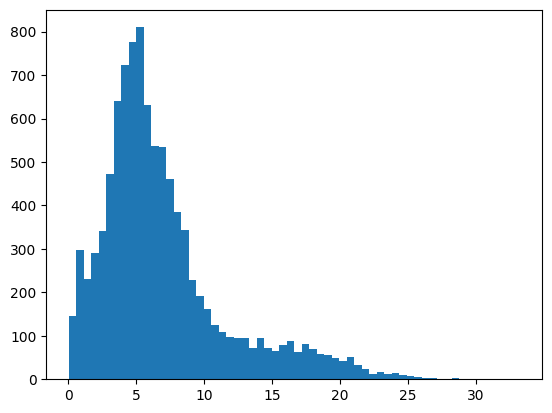

In [15]:
# After running previous cell, all_start_dists has all the distances from ball carrier to tackler at playstart
# for outlier using 1.5IQR + Q3 

all_start_dists = np.array(all_start_dists)

# print(all_start_dists)

quartile_3 = np.percentile(all_start_dists, 75)
quartile_1 = np.percentile(all_start_dists, 25)

print(quartile_1, quartile_3)
#2.3998176158978235 8.170188186099834
# plt.hist(all_start_dists, bins=50)
potential_tackler_threshold = quartile_3 + 1.5*(quartile_3  - quartile_1)
plt.hist(all_start_dists, bins = 60)

In [16]:
df = all_weeks.merge(plays, on=['gameId', 'playId'], how='inner')

In [17]:
filtered_dfs = []
for gameId, playId, startFrame, def_club in play_nums:
    temp = df[(df['gameId'] == gameId) & (df['playId'] == playId)]
    temp = temp[temp['frameId'] >= startFrame]
    filtered_dfs.append(temp)

filtered_df = pd.concat(filtered_dfs)

In [18]:
# filters for all plays we need
temp_key = pd.MultiIndex.from_tuples([(gameId, playId) for gameId, playId, _, __ in play_nums], 
                                     names=['gameId', 'playId'])

filtered_df.set_index(['gameId', 'playId'], inplace=True)
filtered_df = filtered_df[filtered_df.index.isin(temp_key)].reset_index()
#filtered_df.head()

In [19]:
#filtering for defensive players within the threshold
#look for defensiveTeam
#   condition 1: club = defensive team, if offensive keep em
#   condition 2: dist(start frame), see if its bigger than potential_tackler_threshold, if it is drop em
valid = []
for game_id, play_id, start_frame, def_club in play_nums:
    df2 = filtered_df[(filtered_df['gameId'] == game_id) & (filtered_df['playId'] == play_id)]
    off_club = df2[df2['club'] != def_club]
    start_rows = df2[(df2['club'] == def_club) & (df2['frameId'] == start_frame)]
    
    ball_carrier_name = start_rows['ballCarrierDisplayName'].iloc[0]
    valid_player_names = [player for player in start_rows['displayName'] if 
                     (math.dist([start_rows[start_rows['displayName'] == player]['x'].iloc[0], start_rows[start_rows['displayName'] == player]['y'].iloc[0]],
                                [off_club[off_club['displayName'] == ball_carrier_name]['x'].iloc[0], off_club[off_club['displayName'] == ball_carrier_name]['y'].iloc[0]])
                                < potential_tackler_threshold)]
    filtered_df2 = df2[df2['displayName'].isin(valid_player_names)]
    valid.append(off_club)
    valid.append(filtered_df)

#cool = pd.concat(valid)

In [ ]:
cool = pd.concat(valid)

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skewnorm

# Number of samples
n = 10000

# Generate a normal distribution for x
y = np.random.normal(0, 1, n)

# Generate a skewed normal distribution for y
# Here, 'a' is the skewness parameter
a = 5
x = skewnorm.rvs(a, size=n)

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(x, y, alpha=0.5)
plt.title("Bivariate Distribution with Normal and Skewed Normal Variables")
plt.xlabel("X (Normal Distribution)")
plt.ylabel("Y (Skewed Normal Distribution)")
plt.grid(True)
plt.show()

x_points = np.linspace(-3, 3, 1000)
y_points = np.linspace(-3, 3, 1000)

# Calculating the PDFs of X and Y at these points
pdf_x_points = norm.pdf(x_points, loc = 0, scale = 1)
pdf_y_points = skewnorm.pdf(y_points, a)

# Creating a meshgrid for the joint distribution
X, Y = np.meshgrid(x_points, y_points)
joint_pdf = np.outer(pdf_y_points, pdf_x_points)

# Plotting the joint PDF
plt.figure(figsize=(10, 6))
plt.contourf(X, Y, joint_pdf, cmap="viridis")
plt.colorbar(label='Probability Density')
plt.title("Joint PDF of X (Normal) and Y (Skewed Normal)")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

ModuleNotFoundError: No module named 'scipy'